<a href="https://colab.research.google.com/github/ITAM-DS/deep-learning/blob/ag%2Fclasificacion/02_clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase.

Trabajaremos con un conjunto de datos _estandar_ para probar algoritmos de clasificación. 
El conjunto de datos es _parecido_ al conjunto de clasificacion de dígitos MNIST aunque posee un complejidad mayor [[Xiao et al., 2018]](https://arxiv.org/abs/1708.07747). 

El ejemplo está basado en la publicación multimedia [[Zhang et al., 2020]](https://d2l.ai/d2l-en.pdf). Por simplicidad, nos centraremos en la versión del código basado en `Tensorflow` y `Keras`. 



In [1]:
# !pip install -U d2l
from d2l import tensorflow as d2l
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Podemos decargar el conjunto de datos con las herramientas que incluye el módulo. 

In [2]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

Las imágenes son de $28 \times 28$ pixeles y representan 10 categorías. Las clases están balanceadas y en total hay 60K observaciones en el conjunto de entrenamiento y 10K en el de prueba. 

In [3]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

La función de abajo convierte las etiquetas (numéricas) en etiquetas legibles.

In [4]:
def get_fashion_mnist_labels(labels):  
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

También podemos incluir una función que imprima las imagénes. 

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy(), cmap = 'gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    
    return axes

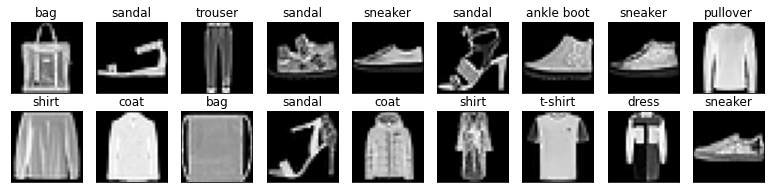

In [6]:
index = np.random.randint(60000, size = 18)

X = tf.constant(mnist_train[0][index])
y = tf.constant(mnist_train[1][index])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

## Carga de datos completa

La función de abajo carga el conjunto de datos y se encarga de estandarizar y construir los iteradores para el entrenamiento por bloques. 

In [7]:
def load_data_fashion_mnist(batch_size, resize=None):   
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [8]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

Los datos estructurados de la siguiente forma. ¿Por qué son tensores de 4D?

In [9]:
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(256, 28, 28, 1) <dtype: 'float32'> (256,) <dtype: 'int32'>


### Ejercicios

1. Reducir el tamaño del bloque afecta la implementación de la carga y manipulación?
1. ¿Se te ocurre otra manera de modificar el iterador para construir uno mas eficiente?
1. ¿Qué otros conjuntos de datos están disponibles a traves de Keras?

## El modelo de clasificación 

Ahora si, constuiremos el modelo de clasificación desde zero para entender todo el procedimiento. Primero que nada, exploraremos cómo definir la función `softmax`. Para esto veamos como funciona el operador `reduce_sum`. 

In [10]:
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

print("Tensor original: ")
print(X.numpy())

print("\nSumando renglones: ")
print(tf.reduce_sum(X, 0, keepdims=True).numpy())

print("\nSumando columnas: ")
print(tf.reduce_sum(X, 1, keepdims=True).numpy())

Tensor original: 
[[1. 2. 3.]
 [4. 5. 6.]]

Sumando renglones: 
[[5. 7. 9.]]

Sumando columnas: 
[[ 6.]
 [15.]]


In [11]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [12]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)

print("Tensor original: ")
print(X.numpy())

print("\nTensor de probabilidades: ")
print(X_prob.numpy()) 

print("\nVerificando probabilidades")
print(tf.reduce_sum(X_prob, 1, keepdims = True).numpy())

Tensor original: 
[[ 2.2934957  -0.5972408  -0.3557507  -0.5816321  -1.0257853 ]
 [ 0.05403499  0.70812184  0.8981618  -2.0050921   0.30568805]]

Tensor de probabilidades: 
[[0.82046056 0.04556452 0.05801024 0.0462813  0.02968331]
 [0.1500815  0.28866458 0.3490815  0.01914519 0.19302729]]

Verificando probabilidades
[[0.9999999]
 [1.0000001]]


### Definir los parámetros del modelo. 

In [13]:
num_inputs = 784
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),
                                 mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

### Definimos el modelo

In [14]:
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

### Definimos la función de pérdida

Supongamos que tenemos dos observaciones, y es un problema de clasificacion con tres etiquetas (por ejemplo: `perro`, `gato`, `pollo`). Tenemos las salidas de un modelo de clasificacion en `y_hat` y la clase a la que pertenece cada uno en `y` (recuerda que `python` empieza desde 0). 

In [15]:
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])


print("Probabilidades: \n%s"%y_hat.numpy())
print("\nEtiquetas: \n%s"%y.numpy())
print("\nCodificacion: \n%s"%tf.one_hot(y, depth=y_hat.shape[-1]).numpy())
print("\nMascara: \n%s"%tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])).numpy())

Probabilidades: 
[[0.1 0.3 0.6]
 [0.3 0.2 0.5]]

Etiquetas: 
[0 2]

Codificacion: 
[[1. 0. 0.]
 [0. 0. 1.]]

Mascara: 
[0.1 0.5]


La máscara nos permite reducir la suma para aquellas etiquetas igual a uno. 

In [16]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(
        y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

### Calculamos la precision de las etiquetas 

In [17]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [18]:
accuracy(y_hat, y) / len(y)

0.5

Podemos calcular la precision para un conjunto partido en bloques aprovechando el iterador que ya tenemos. 
En este caso nos apoyamos de una clase `Accumulator` que nos permitirá llevar un conteo de 

In [19]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

In [20]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
evaluate_accuracy(net, test_iter)

0.0947

In [22]:
def train_epoch_procedure(net, train_iter, loss, updater):  #@save
    """The training loop."""
    # Keep record of 3 metrics: 
    #     1) training loss, 
    #     2) training accuracy, 
    #     3) no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement
            # in this book, e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

El siguiente codigo implementa una animación con la que podemos ver el avance del proceso de entrenamiento.

In [23]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [24]:
def train_procedure(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'], 
                       figsize = [12, 4])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_procedure(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [25]:
class Updater():  #@save
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

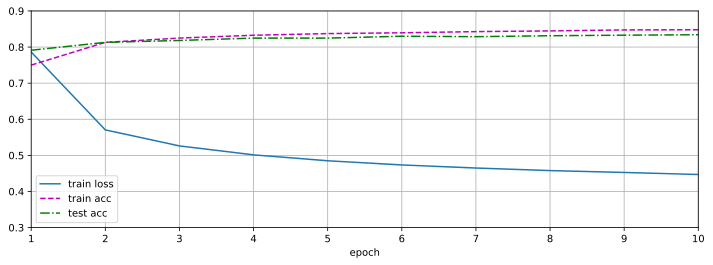

In [26]:
num_epochs = 10
train_procedure(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

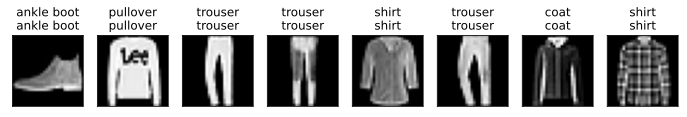

In [27]:
def predict_procedure(net, test_iter, n=6):  #@save
    """Predict labels."""
    for kk, (X, y) in enumerate(test_iter):
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_procedure(net, test_iter, n = 8)

### Ejercicios

1. ¿Por qué se necesita la opción de `keep_dims` en el operador `reduce_sum`?
1. Explora casos en los que el clasificador tuvo problemas para etiquetar.
1. Implementamos la función softmax como esta expresada matematicamente. Cual sería el problema de utilizarla si una combinación lineal en una de las categorías es igual a 50 y el resto son números entre [-2,2].
1. Es siempre buena idea reportar la etiqueta mas probable. ¿Que sucedería en un diagnóstico médico? 
1. ¿Cual seria el problema de usar regresión _softmax_ para predecir la siguiente palabra cuando tenemos un vocabulario muy grande? 